# Statistiques descriptives avec scikit-learn - correction

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

### Prérequis de l'énoncé

In [ ]:
import pyensae
f = pyensae.download_data("dads2010_gf_salaries10_dbase.zip",
                          website="http://telechargement.insee.fr/fichiersdetail/dads2010/dbase/")

import pandas
try:
    from dbfread import DBF
    use_dbfread = True
except ImportError as e :
    use_dbfread = False
    
if use_dbfread:
    import os
    if not os.path.exists("salaries2010.db3"):
        print("convert dbase into sqllite")
        from pyensae.datasource import dBase2sqllite  # fonction ajoutée 10/2014
        dBase2sqllite("salaries2010.db3", "varlist_salarié.dbf", overwrite_table="varlist")
        dBase2sqllite("salaries2010.db3", "varmod_salarie.dbf", overwrite_table="varmod")
        dBase2sqllite("salaries2010.db3", 'salaries10.dbf', overwrite_table="salaries", fLOG = print)
else :
    print("use of zipped version")
    import pyensae
    db3 = pyensae.download_data("salaries2010.zip")

### Exercice 1 : CAH (classification ascendante hiérarchique)

#### version scikit-learn

Le point commun de ces méthodes est qu'elles ne sont pas supervisées. L'objectif est de réduire la complexité des données. Réduire le nombre de dimensions pour l'ACP ou segmenter les observations pour les k-means et la CAH.

In [ ]:
import pandas, numpy, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pyensae
pyensae.download_data("eleve_region.txt")
df = pandas.read_csv("eleve_region.txt",sep="\t",encoding="utf8",index_col=0)
print(df.shape)
df.head(n=5)

(27, 21)


,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
﻿académie,,,,,,,,,,,,,,,,,,,,,
Aix-Marseille,241357,242298,242096,242295,243660,244608,245536,247288,249331,250871,...,250622,248208,245755,243832,242309,240664,240432,241336,239051,240115
Amiens,198281,196871,195709,194055,192893,191862,189636,185977,183357,180973,...,175610,172110,168718,165295,163116,162548,163270,164422,165275,166345
Besançon,116373,115600,114282,113312,112076,110261,108106,105463,103336,102264,...,100117,98611,97038,95779,95074,94501,94599,94745,94351,94613
Bordeaux,253551,252644,249658,247708,247499,245757,244992,243047,243592,245198,...,244805,244343,242602,242933,243146,244336,246806,250626,252085,255761
Caen,145435,144369,141883,140658,139585,137704,135613,133255,131206,129271,...,125552,123889,122550,121002,119857,119426,119184,119764,119010,119238


In [ ]:
for c in df.columns:
    if c != "1993":
        df[c] /= df ["1993"]
df["1993"] /= df["1993"]
df.head()

,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
﻿académie,,,,,,,,,,,,,,,,,,,,,
Aix-Marseille,1.0,1.003899,1.003062,1.003886,1.009542,1.013470,1.017315,1.024574,1.033038,1.039419,...,1.038387,1.028385,1.018222,1.010255,1.003944,0.997129,0.996168,0.999913,0.990446,0.994854
Amiens,1.0,0.992889,0.987029,0.978687,0.972826,0.967627,0.956400,0.937947,0.924733,0.912710,...,0.885662,0.868011,0.850904,0.833640,0.822651,0.819786,0.823427,0.829237,0.833539,0.838936
Besançon,1.0,0.993358,0.982032,0.973697,0.963076,0.947479,0.928961,0.906250,0.887972,0.878761,...,0.860311,0.847370,0.833853,0.823035,0.816976,0.812053,0.812895,0.814149,0.810764,0.813015
Bordeaux,1.0,0.996423,0.984646,0.976955,0.976131,0.969261,0.966243,0.958572,0.960722,0.967056,...,0.965506,0.963684,0.956817,0.958123,0.958963,0.963656,0.973398,0.988464,0.994218,1.008716
Caen,1.0,0.992670,0.975577,0.967154,0.959776,0.946842,0.932465,0.916251,0.902162,0.888858,...,0.863286,0.851851,0.842644,0.832001,0.824128,0.821164,0.819500,0.823488,0.818304,0.819871


In [ ]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(linkage='ward', compute_full_tree=True).fit(df)
ward

AgglomerativeClustering(affinity='euclidean', compute_full_tree=True,
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=2,
            pooling_func=<function mean at 0x0000026C22ECF488>)

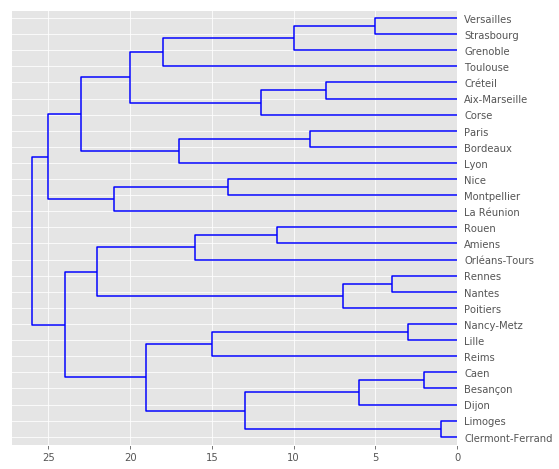

In [ ]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
plt.style.use('ggplot')

dendro = [ ]
for a,b in ward.children_:
    dendro.append([a,b,float(len(dendro)+1),len(dendro)+1])
    # le dernier coefficient devrait contenir le nombre de feuilles dépendant de ce noeud
    # et non le dernier indice
    # de même, le niveau (3ème colonne) ne devrait pas être le nombre de noeud
    # mais la distance de Ward
    
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1,1,1) 
r = dendrogram(dendro, color_threshold=1, labels=df.index, show_leaf_counts=True, ax=ax, orientation = "left")

#### version fastcluster

In [ ]:
import pandas, numpy, matplotlib.pyplot as plt
import pyensae
pyensae.download_data("eleve_region.txt")
df = pandas.read_csv("eleve_region.txt",sep="\t",encoding="utf8",index_col=0)
df.head(n=5)

,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
﻿académie,,,,,,,,,,,,,,,,,,,,,
Aix-Marseille,241357,242298,242096,242295,243660,244608,245536,247288,249331,250871,...,250622,248208,245755,243832,242309,240664,240432,241336,239051,240115
Amiens,198281,196871,195709,194055,192893,191862,189636,185977,183357,180973,...,175610,172110,168718,165295,163116,162548,163270,164422,165275,166345
Besançon,116373,115600,114282,113312,112076,110261,108106,105463,103336,102264,...,100117,98611,97038,95779,95074,94501,94599,94745,94351,94613
Bordeaux,253551,252644,249658,247708,247499,245757,244992,243047,243592,245198,...,244805,244343,242602,242933,243146,244336,246806,250626,252085,255761
Caen,145435,144369,141883,140658,139585,137704,135613,133255,131206,129271,...,125552,123889,122550,121002,119857,119426,119184,119764,119010,119238


In [ ]:
from fastcluster import linkage
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

data_link = linkage(df, method='single', metric='euclidean', preserve_input=True)
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1,1,1) 
dendrogram(data_link, labels=df.index, show_leaf_counts=True, ax=ax, orientation = "left")
plt.xlabel('Académies')
plt.ylabel('Distance')

ImportError: No module named 'fastcluster'

Je reprends également le graphique montrant la matrice de corrélations :

In [ ]:
from scipy.spatial.distance import pdist, squareform

data_dist = pdist(df)

fig = plt.figure(figsize=(8,8))

# x ywidth height
ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
Z1 = dendrogram(data_link, orientation='right',labels=df.index)
ax1.set_xticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z2 = dendrogram(data_link)
ax2.set_xticks([])
ax2.set_yticks([])

#Compute and plot the heatmap
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

D = squareform(data_dist)
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
plt.colorbar(im, cax=axcolor)

### Exercice 2 : régression linéaire

Ce sont trois méthodes supervisées : on s'en sert pour expliquer prédire le lien entre deux variables $X$ et $Y$ (ou ensemble de variables) ou prédire $Y$ en fonction de $X$. On suppose que les données ont déjà été téléchargées (voir l'énoncé de cet exercice). On continue avec l'extraction de l'âge, du sexe et du salaire comme indiqué dans l'énoncé.

In [ ]:
import sqlite3, pandas
con = sqlite3.connect("salaries2010.db3")
df = pandas.io.sql.read_sql("select * from varmod", con)
con.close()

values = df[ df.VARIABLE == "TRNETTOT"].copy()

def process_intervalle(s):
    if "euros et plus" in s : 
        return float ( s.replace("euros et plus", "").replace(" ","") )
    spl = s.split("à")
    if len(spl) == 2 : 
        s1 = spl[0].replace("Moins de","").replace("euros","").replace(" ","")
        s2 = spl[1].replace("Moins de","").replace("euros","").replace(" ","")
        return (float(s1)+float(s2))/2
    else : 
        s = spl[0].replace("Moins de","").replace("euros","").replace(" ","")
        return float(s)/2

values["montant"] = values.apply(lambda r : process_intervalle(r ["MODLIBELLE"]), axis = 1)
values.head()

In [ ]:
import sqlite3, pandas
con = sqlite3.connect("salaries2010.db3")
data = pandas.io.sql.read_sql("select TRNETTOT,AGE,SEXE from salaries", con)
con.close()

salaires = data.merge ( values, left_on = "TRNETTOT", right_on="MODALITE" )
salaires["M"] = salaires.apply( lambda r : 1 if r["SEXE"] == "1" else 0, axis=1)
salaires["F"] = salaires.apply( lambda r : 1 if r["SEXE"] == "2" else 0, axis=1)
data = salaires[["AGE","M","F","montant"]]
data = data [data.M + data.F > 0]
data.head()

On supprime les valeurs manquantes :

In [ ]:
nonull = data.dropna().copy()
nonull.shape

#### version scikit-learn

La [régression linéraire](http://scikit-learn.org/stable/modules/linear_model.html) suit :

In [ ]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit (nonull [["AGE","M"]], nonull.montant)
clf.coef_, clf.intercept_, "R^2=",clf.score(nonull [["AGE","M"]], nonull.montant)

On prend un échantillon aléatoire :

In [ ]:
import random
val = nonull.copy()
val["rnd"] = val.apply( lambda r : random.randint(0,1000), axis=1)
ech = val[val["rnd"] == 1]
ech.shape

On sépare homme et femmes :

In [ ]:
homme = ech [ ech.M == 1]
femme = ech [ ech.M == 0]

predh = clf.predict(homme[["AGE","M"]])
predf = clf.predict(femme[["AGE","M"]])

import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.plot(homme.AGE, homme.montant, "r.")
plt.plot(femme.AGE + 0.2, femme.montant, "b.")
plt.plot(homme.AGE, predh, "ro-", label="hommes")
plt.plot(femme.AGE, predf, "bo-", label="femmes")
plt.legend()

#### version statsmodels

In [ ]:
import statsmodels.api as sm
nonull["one"] = 1.0  # on ajoute la constante
model = sm.OLS(nonull.montant, nonull [["AGE","M", "one"]])
results = model.fit()
print("coefficients",results.params)
results.summary()

On reproduit le même dessin :

In [ ]:
import random
val = nonull.copy()
val["rnd"] = val.apply( lambda r : random.randint(0,1000), axis=1)
ech = val[val["rnd"] == 1]

In [ ]:
homme = ech [ ech.M == 1]
femme = ech [ ech.M == 0]

predh = results.predict(homme[["AGE","M","one"]])
predf = results.predict(femme[["AGE","M","one"]])

import matplotlib.pyplot as plt
def graph(homme, femme, predh, predf):
    fig = plt.figure(figsize=(16,6))
    ax = plt.subplot("111")
    ax.plot(homme.AGE, homme.montant, "r.")
    ax.plot(femme.AGE + 0.2, femme.montant, "b.")
    ax.plot(homme.AGE, predh, "ro-", label="hommes")
    ax.plot(femme.AGE, predf, "bo-", label="femmes")
    ax.legend()
    return ax

graph(homme, femme, predh, predf)

On ajoute l'intervalle de confiance sur un échantillon :

In [ ]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

prstd, iv_l, iv_u = wls_prediction_std(results)

val = nonull.copy()
val["rnd"] = val.apply( lambda r : random.randint(0,1000), axis=1)
val["pred"] = prstd
val["up"] = iv_u
val["down"] = iv_l

ech = val [ val["rnd"] == 1 ]
ech.head()

Puis on l'ajoute au graphe précédent :

In [ ]:
homme = ech [ ech.M == 1]
femme = ech [ ech.M == 0]

predh = results.predict(homme[["AGE","M","one"]])
predf = results.predict(femme[["AGE","M","one"]])

ax = graph(homme, femme, predh, predf)
ax.plot(homme.AGE, homme.up, 'r-')
ax.plot(homme.AGE, homme.down, 'r-')
ax.plot(femme.AGE, femme.up, 'b-')
ax.plot(femme.AGE, femme.down, 'b-')
ax